In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

" %matplotlib inline sets the backend of matplotlib to\nthe 'inline' backend. When using the 'inline' backend,\nyour matplotlib graphs will be included in your notebook,\nnext to the code."

### The Visualization 

In [2]:
from graphviz import Digraph

def trace(root):
    '''
    Build a set of all nodes and edges in a graph,
    the order does not matter
    '''
    nodes, edges = set(), set()
    
    def build(v): # a heuristic topological sort function
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v)) # define edge like this
                build(child)

    build(root)
    return nodes, edges

# first have an scheme of your desired graph based on the nodes and operations
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR : left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular (record') node for it
        # a visual node
        dot.node(name=uid, label=f'{n.label} | data: {n.data} | grad: {n.grad}', shape='record')
        if n._op:
            # if this value is result of some operation, create an operation node for it
            dot.node(name=uid+n._op , label=n._op) # n._op is a string
            # and connect the op node to the value node
            dot.edge(uid+n._op , uid)
            for child in n._prev:
                dot.edge( str(id(child)) , uid+n._op)
    return dot

## engine file

Let's write our backprop as a method that can run from any node as root:

In [9]:
class Value:
    
    def __init__(self, data, _prev=(), _op='', label=''):
        self.data = data
        self._prev = set(_prev) # the order does not matter, use set instead of list
        self._op = _op
        self.label = label

        self.grad = 0.0

        # After the forwrd path (when we have the data vlaue of all nodes)
        # we start the backprop (to get the gradients for each node)
        # the output node of each operation knows the operation and children
        # since we dont have a backprop for leaf nodes, and 
        # each operation has different local gradient
        # we can't define a general method in the class.
        # so at the time of doing the operation,
        # we can both define the local gradiant function
        # and store the whole chain rule function in an attribute to call later.
        # then call the local this function attribute from end node to the begining.
        self._backprop = lambda: None
    
    def __repr__(self) -> str:
        return f'Value({self.label}:{self.data})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backprop():
            # partial derivatives for each input:
            self.grad = out.grad
            other.grad = out.grad

        out._backprop = _backprop
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backprop():
            # partial derivatives for each input:
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        
        out._backprop = _backprop
        return out
    
    def exp(self):
        out = Value(np.exp(self.data), (self,), 'exp')
        
        def _backprop():
            self.grad = np.exp(self.data) * out.grad
        
        out._backprop = _backprop
        return out
    
    def tanh(self):
        tanh = (np.exp(2*self.data) - 1)/(np.exp(2*self.data) + 1)
        out = Value( tanh, (self,), 'tanh')
        
        def _backprop():
            self.grad = (1 - tanh**2) * out.grad
        
        out._backprop = _backprop
        return out
    
    def backprop(self):
        topo_sort_list = []
        visited = set() # the order does not matter, use set instead of list
        
        def build_topo(root):
            if root not in visited:
                visited.add(root)
                # Appending to topo_sort before its children are processed
                # will give us out to left sort,
                # but not out to leaf sort in case of b (bias leaf), try it & see it
                for child in root._prev:
                    build_topo(child)
                # Appending after its children are processed
                # will give us leaf to out sort
                topo_sort_list.append(root)
        
        build_topo(root=self)
        
        self.grad = 1.0
        for node in reversed(topo_sort_list):
            node._backprop()


## NN architecture file
### A single Neuron with 2 inputs and one output

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of Neuron
b = Value(10.7, label='b')

# we do the multiplication one-by-one
# so that we have the pointers to all intermediate values

x1w1 = x1*w1;               x1w1.label = 'x1w1'
x2w2 = x2*w2;               x2w2.label = 'x2w2'

x1w1addx2w2 = x1w1 + x2w2;  x1w1addx2w2.label = 'x1w1addx2w2'
n = x1w1addx2w2 + b;        n.label = 'n'

o = n.tanh();                o.label = 'o'

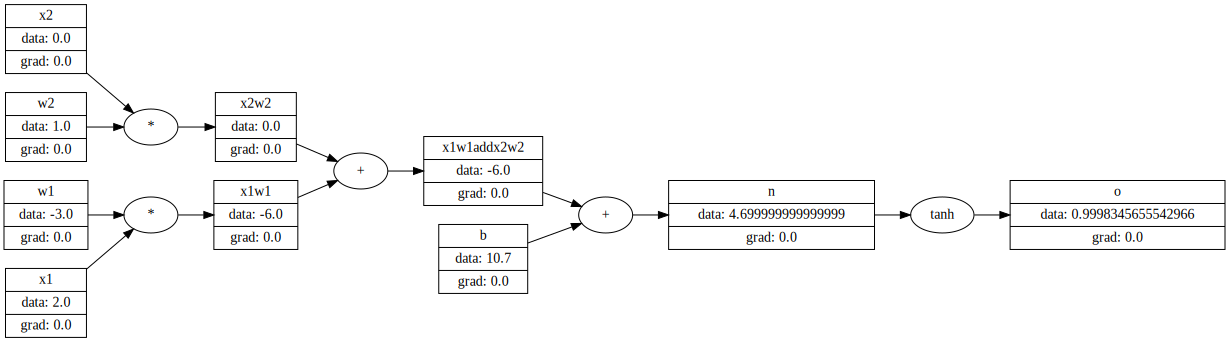

In [11]:
draw_dot(o)

In [12]:
o.backprop()

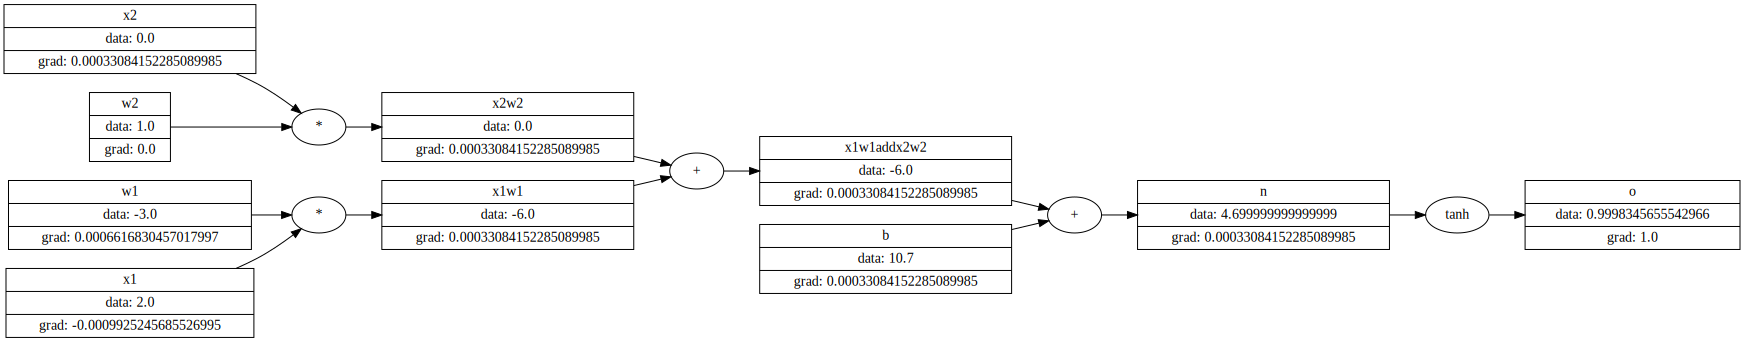

In [13]:
draw_dot(o)

## Multivariable General Chain Rule

### Problem
What if one node was involved in more than one operation!!

Then in  we overwrite the gradient from one operation on another operation
like:
n = x1 + x1 -> dn/dx1 = 2
but below you see that dn/dx1 = 1!!

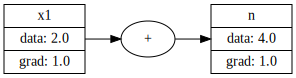

In [14]:
# input x1
x1 = Value(2.0, label='x1')

n = x1 + x1;        n.label = 'n'
n.backprop()
draw_dot(n)

or like here:
we x1.grad from * operation overwrite the + operation and make it 0!!

we can say + is one neuron and * is another neuron
so if we have multiple neurons, what should we do!?

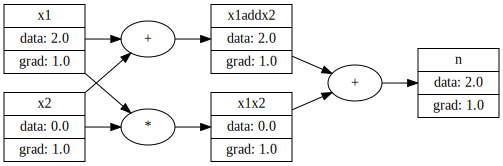

In [15]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

x1x2 = x1 * x2;         x1x2.label = 'x1x2'
x1addx2 = x1 + x2;      x1addx2.label = 'x1addx2'
n = x1x2 + x1addx2;     n.label = 'n'
n.backprop()
draw_dot(n)

### Solution:
the general chain rule -> accumilate gradients from different paths

## updated engine file

In [16]:
class Value:
    
    def __init__(self, data, _prev=(), _op='', label=''):
        self.data = data
        self._prev = set(_prev) # the order does not matter, use set instead of list
        self._op = _op
        self.label = label

        self.grad = 0.0

        # After the forwrd path (when we have the data vlaue of all nodes)
        # we start the backprop (to get the gradients for each node)
        # the output node of each operation knows the operation and children
        # since we dont have a backprop for leaf nodes, and 
        # each operation has different local gradient
        # we can't define a general method in the class.
        # so at the time of doing the operation,
        # we can both define the local gradiant function
        # and store the whole chain rule function in an attribute to call later.
        # then call the local this function attribute from end node to the begining.
        self._backprop = lambda: None
    
    def __repr__(self) -> str:
        return f'Value({self.label}:{self.data})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backprop():
            # partial derivatives for each input:
            self.grad += out.grad
            other.grad += out.grad

        out._backprop = _backprop
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backprop():
            # partial derivatives for each input:
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backprop = _backprop
        return out
    
    def exp(self):
        out = Value(np.exp(self.data), (self,), 'exp')
        
        def _backprop():
            self.grad += np.exp(self.data) * out.grad
        
        out._backprop = _backprop
        return out
    
    def tanh(self):
        tanh = (np.exp(2*self.data) - 1)/(np.exp(2*self.data) + 1)
        out = Value( tanh, (self,), 'tanh')
        
        def _backprop():
            self.grad += (1 - tanh**2) * out.grad
        
        out._backprop = _backprop
        return out
    
    def backprop(self):
        topo_sort_list = []
        visited = set() # the order does not matter, use set instead of list
        
        def build_topo(root):
            if root not in visited:
                visited.add(root)
                # Appending to topo_sort before its children are processed
                # will give us out to left sort,
                # but not out to leaf sort in case of b (bias leaf), try it & see it
                for child in root._prev:
                    build_topo(child)
                # Appending after its children are processed
                # will give us leaf to out sort
                topo_sort_list.append(root)
        
        build_topo(root=self)
        
        self.grad = 1.0
        for node in reversed(topo_sort_list):
            node._backprop()


## NN architecture file
### A single Neuron with 2 inputs and one output

In [17]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of Neuron
b = Value(10.7, label='b')

# we do the multiplication one-by-one
# so that we have the pointers to all intermediate values

x1w1 = x1*w1;               x1w1.label = 'x1w1'
x2w2 = x2*w2;               x2w2.label = 'x2w2'

x1w1addx2w2 = x1w1 + x2w2;  x1w1addx2w2.label = 'x1w1addx2w2'
n = x1w1addx2w2 + b;        n.label = 'n'

o = n.tanh();                o.label = 'o'
o.backprop()

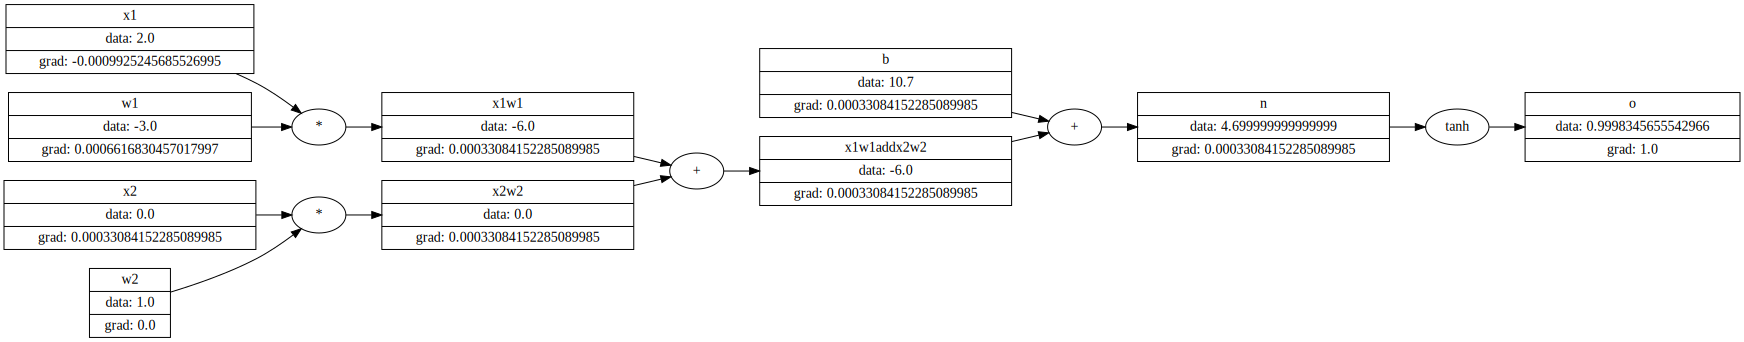

In [18]:
draw_dot(o)

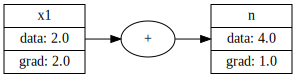

In [19]:
# input x1
x1 = Value(2.0, label='x1')

n = x1 + x1;        n.label = 'n'
n.backprop()
draw_dot(n)

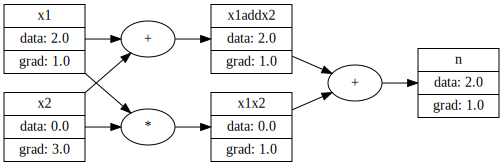

In [20]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

x1x2 = x1 * x2;         x1x2.label = 'x1x2'
x1addx2 = x1 + x2;      x1addx2.label = 'x1addx2'
n = x1x2 + x1addx2;     n.label = 'n'
n.backprop()
draw_dot(n)